In [3]:
import cvxpy as cvx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
#Generator's parameters
Gen = pd.DataFrame.from_dict({
    'p1': [0.12, 14.80, 89, 1.2, -5.00, 3.00, 28, 200, 40, 40], 
    'p2': [0.17, 16.57, 83, 2.3, -4.24, 6.09, 20, 290, 30, 30],
    'p3': [0.15, 15.55, 100, 1.1, -2.15, 5.69, 30, 190, 30, 30],
    'p4': [0.19, 16.21, 70, 1.1, -3.99, 6.20, 20, 260, 50, 50]}, 
                 orient='index', columns=['a', 'b', 'c', 'd', 'e', 'f', 'Pmin', 'Pmax', 'RU', 'RD']);
Gen


,a,b,c,d,e,f,Pmin,Pmax,RU,RD
p1,0.12,14.80,89,1.2,-5.00,3.00,28,200,40,40
p2,0.17,16.57,83,2.3,-4.24,6.09,20,290,30,30
p3,0.15,15.55,100,1.1,-2.15,5.69,30,190,30,30
p4,0.19,16.21,70,1.1,-3.99,6.20,20,260,50,50


In [5]:
Load = pd.DataFrame.from_dict({
    'Load':[510,530,516,510,515,544,646,686,741,734,748,760,754,700,686,720,714,761,727,714,618,584,578,544]},
    orient='columns')
Load

,Load
0,510
1,530
2,516
3,510
4,515
5,544
6,646
7,686
8,741
9,734


In [6]:
T = len(Load.index)
Gen_num = len(Gen.index)
#ESS parameters
SOC_0 = 100;
SOC_max = 300;
SOC_min = 0.2*SOC_max
Pd_max = 0.2*SOC_max; #Discharge limits
Pd_min = 0;
Pc_max = 0.2*SOC_max; #Charge limits
Pc_min = 0;
eta_c = 0.95; #Charge efficiency
eta_d = 0.9; #Discharge efficiency

In [7]:
#Variables
p = cvx.Variable(Gen_num,T) #Power generation (g1,g2,g3,g4)
SOC = cvx.Variable(T)
Pd = cvx.Variable(T)
Pc = cvx.Variable(T)

P_min = Gen.loc[:,'Pmin'].values #Power generation limits
P_max = Gen.loc[:,'Pmax'].values
RU = Gen.loc[:,'RU'].values #RampUp
RD = Gen.loc[:,'RD'].values #RampDown
a = Gen.loc[:,'a'].values #price coefficients
b = Gen.loc[:,'b'].values
c = Gen.loc[:,'c'].values
Pl = Load.loc[:,'Load'].values #Load

A = np.eye(Gen_num)



In [8]:
samples = []
for t in range(T):
    cost = sum(a*A*p[:,t]**2 + b*A*p[:,t] + c[:, np.newaxis]) #Generation cost/ objective function
    if t == 0:
        constr = [SOC[t] == SOC_0 + Pc[t]*eta_c - Pd[t]/eta_d] #State of charge
    else:
        constr = [p[:,t] - p[:,t-1] <= RU, #RampUp
                  p[:,t-1] - p[:,t] <= RD, #RampDown
                  SOC[t] == SOC[t-1] + Pc[t]*eta_c - Pd[t]/eta_d #State of charge
                  ]    
        
    constr.extend([SOC[t] >= SOC_min, #Battery's charge limits
                  SOC[t] <= SOC_max,
                  Pd[t] >= Pd_min, #Discharge limits
                  Pd[t] <= Pd_max,
                  Pc[t] >= Pc_min, #Charge limits
                  Pc[t] <= Pc_max, 
                  p[:,t] >= P_min, #Generation limits
                  p[:,t] <= P_max, 
                  sum(p[:,t]) + Pd[t] >= Pl[t] + Pc[t]]) #Power balance
    
    samples.append(cvx.Problem(cvx.Minimize(cost), constr))
prob = sum(samples)

prob.constraints += [SOC[T-1] == SOC_0] #
prob.solve(solver=cvx.ECOS_BB)


IndexError: Too many indices for expression.

In [ ]:
P = sum(p.value)
P

In [ ]:
SOC.value

In [ ]:
Pd.value

In [ ]:
Pc.value

NameError: name 'P' is not defined

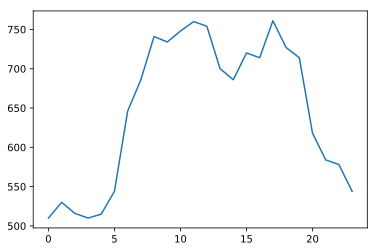

In [9]:
plt.figure()
plt.plot(Pl,label="Demand") 
plt.plot(P.A.flatten(),label="Generation") 
plt.plot(SOC.value.A.flatten(),label="SOC",marker = 'o') 
plt.xlabel('Time(h)')
plt.ylabel('Power/Energy')
plt.legend(loc='right')
plt.grid()


In [10]:
x = range(1,T+1)
plt.figure()
 
plt.bar(x,Pd.value.A.flatten(),label="Pd", width = 0.4) 
plt.bar(x,Pc.value.A.flatten(),label="Pc", width = 0.4) 
plt.xlabel('Time(h)')
plt.ylabel('Charge/Discharge (MW)')
plt.legend(loc='upper right')
plt.grid()

AttributeError: 'NoneType' object has no attribute 'A'

<Figure size 432x288 with 0 Axes>

In [11]:
plt.figure()
plt.plot(p[0,:].value.A.flatten(),label="g1", marker = '.') 
plt.plot(p[1,:].value.A.flatten(),label="g2", marker = '.') 
plt.plot(p[2,:].value.A.flatten(),label="g3", marker = '.')
plt.plot(p[3,:].value.A.flatten(),label="g4", marker = '.')
plt.xlabel('Time(h)')
plt.ylabel('Power/Energy')
plt.legend(loc='upper right')
plt.grid()

IndexError: Too many indices for expression.

<Figure size 432x288 with 0 Axes>

In [2]:
print (cvx.__version__)

1.0.6
